# Locally Linear Embedding (40 P)

In this assignment we will look at locally linear embedding and experiment with it on artificially generated datasets. The effects of neighbourhood size and noise on result quality will be analyzed.

Information about the algorithm, publications and demos can be found at http://www.cs.nyu.edu/~roweis/lle/

A guide for plotting can be found here: http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-4-Matplotlib.ipynb

We first start by importing some basic python libraries for numerical computation and plotting.

In [1]:
import matplotlib
import numpy as np
from numpy.linalg import inv, eigh
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

The file `utils.py` contains several methods to generate pseudo-random three-dimensional datasets. They all have a low-dimensional manifold structure. The following code plots each dataset with default generation parameters (`N=1000` examples, and Gaussian noise of scale `0.25`).

spiral


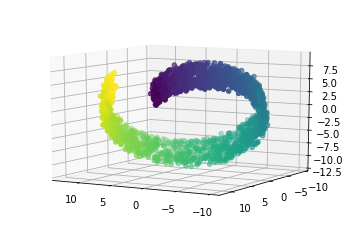

roll


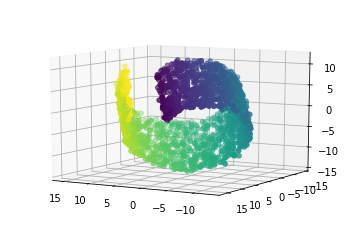

wave


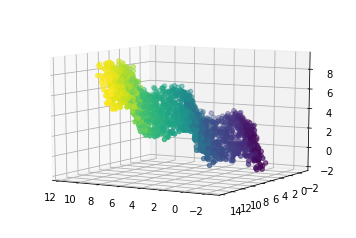

fold


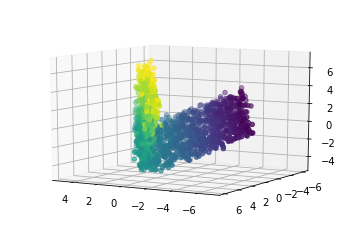

In [2]:
import utils
%matplotlib inline

for dataset in [utils.spiral,utils.roll,utils.wave,utils.fold]:
    print(dataset.__name__)
    data,color = dataset(N=2000,noise=0.25)
    color = np.squeeze(color)
    plt.figure()
    ax = plt.gca(projection='3d')
    ax.view_init(elev=10., azim=120)
    ax.scatter(data[:,0],data[:,1],data[:,2],c=color)
    plt.show()

## Implementing LLE (20 P)

**Implement a function `LLE(data,k)`**. The function takes as input the high-dimensinonal data the number of neighbors `k` used for reconstruction in the LLE algorithm. It returns the resulting 2D embedding (a two-dimensional array of size `Nx2`). A backbone of the implementation is given below. The implementation of LLE is described in the paper "An Introduction to LLE" linked from ISIS.

*Reminder: During computation, you need to solve the problem Cw=**1**, where **1** is a column vector (1,1,...,1). In case k>d i.e. the size of the neighbourhood is larger than the number of dimensions of the space we're mapping to, it is necessary to regularize the matrix C. You can do this by adding positive terms on the diagonal. A good starting point is 0.05.*

In [3]:
# Backbone implementation
def LLE(data,k):
    N = len(data)
    W = np.zeros([N,N]) # matrix for storing reconstruction weights
    M = np.zeros([N,N]) # matrix M of which eigenvectors are computed
    E = np.zeros([N,2]) # eigenvectors of M forming the embedding
    
    # Iterate over all data points to find their associated reconstruction weights
    for i in range(N):
        
        # 1. find nearest neighbors of data[i]
        d = np.sum((data-data[i])**2,axis=1)
        d_index = np.argsort(d)
        n = d_index[1:k+1]
        
        # 2. compute local covariance (with diagonal regularization), and invert it
        if k > 2:
            reg_term = 0.05
        else:
            reg_term = 0.00
        C = np.dot((data[n]-data[i]), (data[n]-data[i]).T)
        C = C + np.eye(k) * reg_term
        C_inv = inv(C)
        
        # 3. compute reconstruction weights and store them in the row of the matrix W
        w = np.dot(C_inv, np.ones(k))
        w = w / np.sum(w)
        W[i][n] = w
        
    # 4. Compute the matrix M from W and compute the desired eigenvectors E of M
    M = np.dot((np.eye(N)-W).T, (np.eye(N)-W))
    eig_val, eig_vec = eigh(M)
    E[:,1] = eig_vec[:,1]
    E[:,0] = eig_vec[:,2]
    
    return E

**Test your implementation by running the code below.** It plots the original data (projected on the first two dimensions), and next to it, the two-dimensional embedding. A correct implementation produces a two-dimensional dataset where the manifold is unfolded, and where nearby points in the embedding are also neighbors in the manifold, in particular, neighboring points in the plot should have similar color.

Text(0.5,1,'LLE')

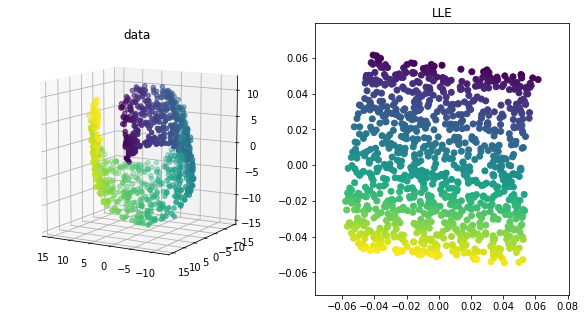

In [4]:
import utils
%matplotlib inline
data,color = utils.roll()
color = np.squeeze(color)
embedding = LLE(data,k=20) 
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1,projection='3d')
ax.view_init(elev=10., azim=120)
ax.scatter(data[:,0],data[:,1],data[:,2],c=color)
ax.set_title('data')

ax = fig.add_subplot(1,2,2)
ax.scatter(embedding[:,0],embedding[:,1],c=color)
ax.set_title('LLE')

## Experiments (20 P)

The function `compare(embed,dataset)`takes as input an embedding function and a dataset and plots the resulting embeddings for various choices of the parameter `k`, in particular, `k=5,20,80`.

In [5]:
def compare(embed, dataset):
    cols = 4
    
    fig = plt.figure(figsize=(3*cols, 3))
    
    # Plot the data
    data, color = dataset()
    color = np.squeeze(color)
    ax = fig.add_subplot(1, cols, 1,projection='3d')
    ax.view_init(elev=10., azim=120)
    ax.scatter(data[:,0],data[:,1],data[:,2],c=color)
    
    ax.set_title('data')
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.set_zticks([], [])

    # Plot embeddings with various parameters K
    for i, k in enumerate([5,20,80]):
        ax = fig.add_subplot(1, cols, 2+i)

        z = embed(data,k=k)

        ax.scatter(z[:,0], z[:,1], c=color)
        ax.set_title('LLE, k=%d'%k)
        ax.set_xticks([], [])
        ax.set_yticks([], [])
    plt.tight_layout()
    plt.show()

### Datasets and optimal parameter `k`

The code below tests the LLE embedding algorithm on each dataset: spiral, roll, wave, and fold. **Explain** what is a good parameter `k` of the LLE algorithm, and how this parameter relates to the various properties of the dataset.

**If k=5: the manifold can falsely be devided into submanifolds, so that the mapping does not reflect the global
properties.
If k=20: the manifold is embedded in a reliable manner.
If k=80: small scale structure are smothed or eliminated, the mapping loses its non-linear character. Also apparently data points are to be considered as neighbours which are behind a "gap" in original space.
The parameter `k`relates to the density of the data points. If the dataset is very dense, there should be a wider range of possible local linear embeddings. On the other hand - if data is relatively sparse - it can be necessary to fine-tune this parameter in order to obtain valuable results.**

spiral


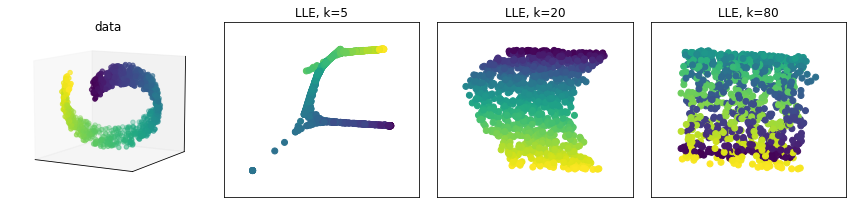

roll


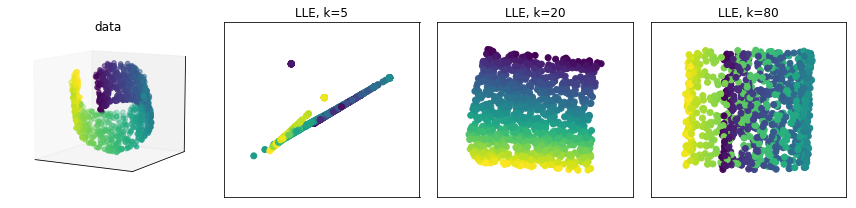

wave


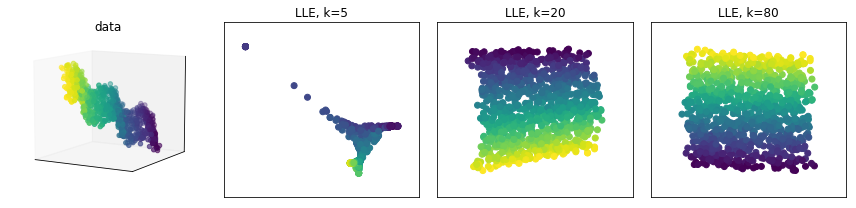

fold


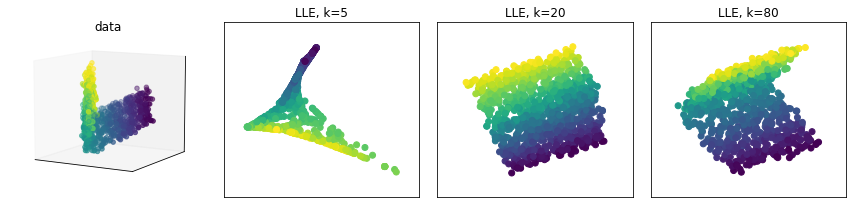

In [6]:
for dataset in [utils.spiral,utils.roll,utils.wave,utils.fold]:
    print(dataset.__name__)
    compare(LLE,dataset)

### LLE and the effect of noise

The code below tests LLE on the spiral dataset with three different levels of noise. **Describe** how the noise affects the embedding.

**The embedding in highly sensitive to noise!
Even small noise greatly affects the embedding (see k=5 with noise=0.1 and without noise).
Even different amounts of noise can change the structure considerably (see e.g. the spiral role k=80)**

noise=0.100


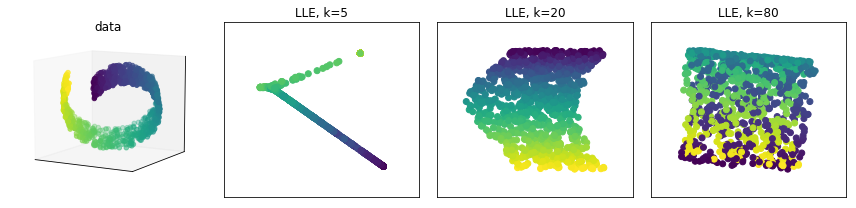

noise=0.300


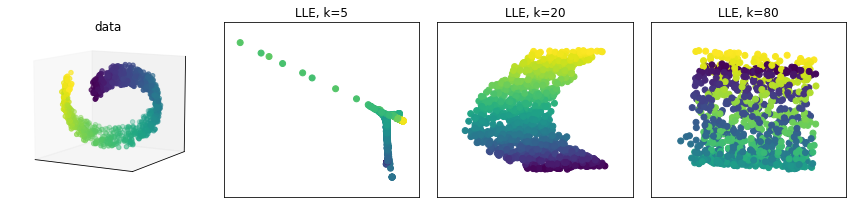

noise=1.000


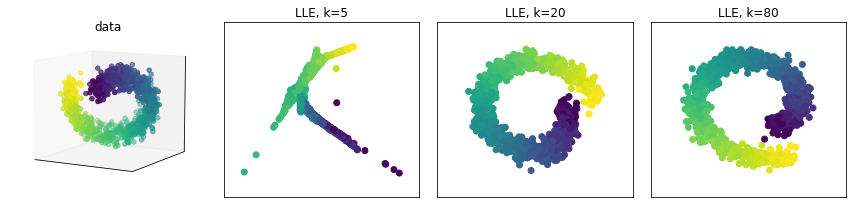

In [7]:
for noise in [0.1,0.3,1.0]:
    print('noise=%.3f'%noise)
    dataset = lambda: utils.spiral(noise=noise)
    compare(LLE,dataset)

### Discussion

* When applying LLE to a 200-dimensional dataset which can't be visualized, how would you assess whether the found embedding is good? Discuss how you would do it or argue why it can't be done.

 **For each point, we would consider its k neighbors and check wheater they are still neighbors in the embedding. This procedure should be conducted for various values of k to find a good embedding.
 For each result we obtain we could calculate the difference (quotient) of the distances between points in the original space and the embedded space and see if there are big deviations. Also maybe in the original algorithm a maximum distance between points to be considered "neighbours" could be set.
 Also the structure of the resulting map could tell us something about the goodness of the embessing. For example thin lines (like in the plots for k=5) could indicate the embedding is bad.
 And last we could also use other dimension reduction or clustering methods (e.g. T-SNE, k-means Clustering, PCA) and compare for example the amount of clusters in the embedded space or the general structure.
 **


* Could utilizing this technique in conjuction with a classifier improve its performance? Which classifiers, if any, would benefit the most?

 **When we have a classifiers that separates two sections of points,then in the embedding these sections should
 also be separated. If this is not the case, then we have proven that the embedding is not appropriate. Due to the linear structure of the embedding, a linear classifier, such as LDA, would be most beneficial.**